# 5.2 Exercise: Modeling Distributions and PDFs
# Rahul Rajeev


**5.1 Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [33]:
# imports
import scipy.stats
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

import numpy as np
import thinkstats2
import thinkplot

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [34]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

A "frozen random variable" can compute its mean and standard deviation.

In [35]:
dist.mean(), dist.std()

(178.0, 7.7)

It can also evaluate its CDF.  How many people are below the mean by more than one standard deviation?  About 16%

In [36]:
dist.cdf(mu - sigma)

0.1586552539314574

Q: How many people are between 5'10" and 6'1"?

In [42]:
# 5'10" in cm = 177.8, 6'1" in cm = 185.4 cm
# we take these values and plug it into dist.cdf() to calculate the percentiles of each height
percentile1 = dist.cdf(177.8)
percentile2 = dist.cdf(185.4)
# If you are at a height of 5'10" you are in the 49th percentile and if you are at a height of 6'1", you are in the 83rd
# percentile
# Then if we subtract these percentiles, we can find approximately the percentage of people between 5'10" and 6'1"
answer = percentile2 - percentile1
percentile1, percentile2, answer

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

A: The percentage of people in this height range is approximately 34%. 

**5.2 Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [43]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

Q: What is the mean height in Pareto world?

In [45]:
# call the mean function on the distribution
pareto_mean = dist.mean()
pareto_mean

2.428571428571429

A: The mean height in Pareto world is 2.42 m.

Q: What fraction of people are shorter than the mean?

In [47]:
# calculate cdf of the mean
dist.cdf(pareto_mean)

0.778739697565288

A: Since the pareto_mean is in the 78th percentile, then 78% of the data is below the pareto_mean.

Q: Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [48]:
# calculate the percent of people above the cdf of 1000
prob = (1-dist.cdf(1000))
# multiply the 7 billion people into the probability to find the number of people taller than 1 km
num_tall_ppl = 7e9 * prob
num_tall_ppl

55602.976430479954

A: The number of people taller than 1km in pareto world is 55,603.

Q: How tall do we expect the tallest person to be?

In [44]:
# Using a ppf to revert the percentile of being the tallest person, the one person out of the 7 billion people into the number
tallest_percentile = 1 - 1/7e9
dist.ppf(tallest_percentile)

A: The height appears to be around 618349 m or 618 km.

**6.1 Exercise:** The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [34]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [35]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [36]:
import hinc
income_df = hinc.ReadData()

In [37]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

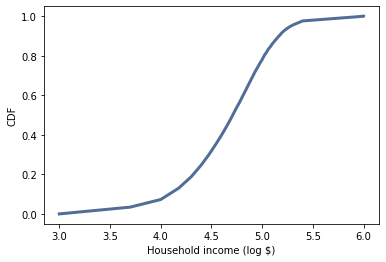

In [38]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [39]:
sample = np.power(10, log_sample)

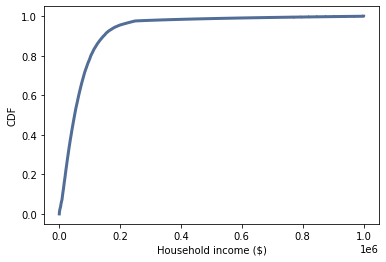

In [40]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Q: Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [41]:
# calculating mean of interpolated sample

Mean(sample)

74278.70753118733

A: The mean of the interpolated sample is $74,278 household income.

In [43]:
# calculating the median of the interpolated sample

Median(sample)

51226.45447894046

A: The median of the interpolated sample is $51,226.

In [44]:
# Calculating Skewness and Pearson's Skewness

Skewness(sample), PearsonMedianSkewness(sample)

(4.949920244429583, 0.7361258019141782)

A: The interpolated sample is highly positively skewed, meaning that the data is heavily distributed on the right
peaked on the right. The pearson median skewness is also positive, meaning that the median is < than the mean, and the distribution is skewed to the right as predicted.

In [46]:
# calculating the fraction of households that report a taxable income below the mean

cdf.Prob(Mean(sample))

0.660005879566872

A: The probability returned is around 66%, so 2/3 of the population reports a taxable income below the mean.

Q: All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.

A: Assuming that this question is rhetorical and doesn't actually ask us to add a row of values to the data frame, changing the
upperbound to 10 million and having a decent amount of people past the million dollars point could cause the data to actually
look skew left. The peak of data will happen around a little bit past the million mark, and the rest of the points will
settle down towards the left. Since the majority of values thus far are up to a million (assuming), then scattering points
in the range of 1 million to 10 million could have effects on the shape of the graph. 